# Step by step understanding of inputs and outputs

In [102]:
import os
import sys
import glob
from tqdm import tqdm

import numpy as np
import torch
import torchio

### Import functions from utils directory 

In [103]:
import imp

import utils.data_processor as data_processor
imp.reload(data_processor)
from utils.data_processor import *

import utils.visualization_tools as visualization_tools
imp.reload(visualization_tools)
from utils.visualization_tools import *

import utils.routine as routine
imp.reload(routine)
from utils.routine import *

import utils.metrics as metrics
imp.reload(metrics)
from utils.metrics import *

In [104]:
fcd_pirogov_seg_data = data_processor.DataMriSegmentation(sample='pirogov', prefix='fcd', mask='combined', ignore_missing=True,
                         coord_min=(30,30,30, ), img_shape=(192, 192, 192, ),
                         image_path= '../datasets/fcd_classification_bank',
                         targets_path= 'targets/targets_fcd_bank.csv',
                         mask_path='../datasets/ellipse_masks/combined')

print('\n')
print(f'Dataset size: {len(fcd_pirogov_seg_data)}')
print(f'Labels distribution: {np.unique(fcd_pirogov_seg_data.target, return_counts=True)}\n')

#Example of data 
img, seg = fcd_pirogov_seg_data[1]
print("Image shape: {}".format(img.shape))
print("Segmentation shape: {}".format(seg.shape))

 13%|█▎        | 2/15 [00:00<00:00, 17.69it/s]

Assembling data for: pirogov sample.


100%|██████████| 15/15 [00:00<00:00, 20.66it/s]




Dataset size: 15
Labels distribution: (array([1]), array([15]))

Image shape: torch.Size([1, 192, 192, 192])
Segmentation shape: torch.Size([1, 192, 192, 192])


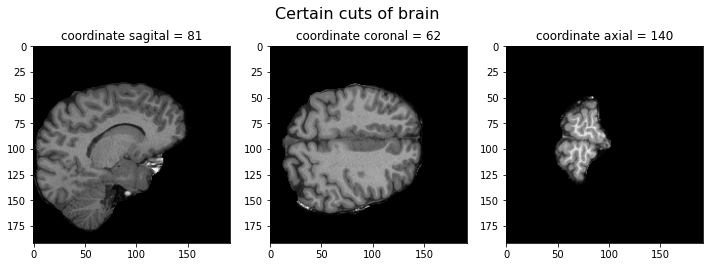

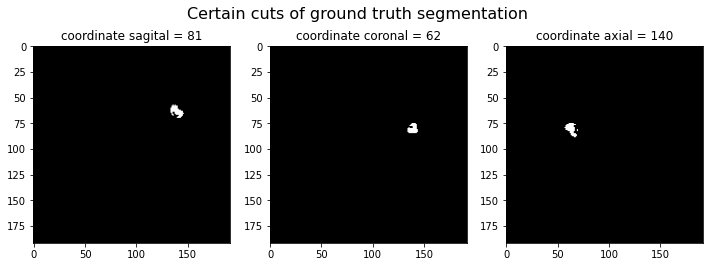

In [105]:
plot_certain_cuts(img,get_center_coord_of_bb(seg),  'brain')
plot_certain_cuts(seg, get_center_coord_of_bb(seg), 'ground truth segmentation')

### Preprocessing data

In [5]:
histogram_landmarks_path = 'landmarks/fcd_train_data_landmarks.npy'
# for recreating landmarks remove # below 
# image_paths = list(fcd_data.img_files[train_idx].values)
# landmarks = HistogramStandardization.train(image_paths, output_path=histogram_landmarks_path)
landmarks = np.load(histogram_landmarks_path)


training_transform = Compose([
    HistogramStandardization(landmarks={'MRI': landmarks}),
#     RandomBiasField(),
    ZNormalization(masking_method=ZNormalization.mean),
    CropOrPad((200, 200, 200)),
#     RandomFlip(axes=(0,)),
#     OneOf({
#         RandomAffine(): 0.8,
#         RandomElasticDeformation(): 0.2,
#     }),
])

validation_transform = Compose([
    HistogramStandardization(landmarks={'MRI': landmarks}),
    ZNormalization(masking_method=ZNormalization.mean),
    CropOrPad((200, 200, 200)),
])

### Getting torchio preprocessed dataset from data 

In [6]:
dataset = get_torchio_dataset(fcd_pirogov_seg_data.img_files, fcd_pirogov_seg_data.img_seg, training_transform)

### Splitting data into train and test parts 

In [7]:
from sklearn.model_selection import StratifiedKFold, ShuffleSplit
cv = ShuffleSplit(n_splits = 1,  test_size = 0.3, random_state = 42)
cv_splits = list(cv.split(X=np.arange(len(fcd_pirogov_seg_data)), y=fcd_pirogov_seg_data.target))

### Creating dataloaders for model 

In [8]:
training_loader, validation_loader = get_loaders(fcd_pirogov_seg_data, cv_splits[0],
        training_transform = training_transform,
        validation_transform = validation_transform)

Training set: 10 subjects
Validation set: 5 subjects
Mask type is combined


In [26]:
random_batch = next(iter(validation_loader))

In [27]:
#random_batch['MRI'][DATA]

In [28]:
#random_batch['LABEL'][DATA]

### Getting model and optimizer 

In [12]:
!nvidia-smi

Sun Feb 28 10:05:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 440.82       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:05:00.0 Off |                  N/A |
|  0%   41C    P8    11W / 280W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
|  0%   46C    P2    93W / 280W |   9349MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [13]:
torch.cuda.set_device(0)

In [14]:
torch.cuda.current_device()

0

In [15]:
torch.cuda.empty_cache()

model, optimizer, scheduler = get_model_and_optimizer(device, out_channels_first_layer = 8)

In [29]:
def forward(model, input_):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        logits = model(input_)
    return logits

In [30]:
inputs, targets = prepare_batch(random_batch, device)

In [20]:
print(f'inputs.shape: {inputs.shape}')
print(f'targets.shape: {targets.shape}')

inputs.shape: torch.Size([1, 1, 200, 200, 200])
targets.shape: torch.Size([1, 2, 200, 200, 200])


In [21]:
result = forward(model, inputs)

In [22]:
print(f'result.shape: {result.shape}')

result.shape: torch.Size([1, 2, 200, 200, 200])


In [23]:
probabilities = F.softmax(result, dim = CHANNELS_DIMENSION)

In [24]:
print(f'probabilities.shape: {probabilities.shape}') 

probabilities.shape: torch.Size([1, 2, 200, 200, 200])


In [25]:
(get_dice_score(probabilities, targets).cpu().detach()*torch.tensor([1,0])).sum()

tensor(0.0002, dtype=torch.float64)

In [18]:
run_epoch(0, Action.TRAIN, training_loader, model, optimizer, scheduler = False, ratio = False, experiment = False, loss_type = False)

100%|██████████| 10/10 [00:34<00:00,  3.40s/it]


array([0.99954021, 0.99914789, 0.9994812 , 0.9991917 , 0.99906784,
       0.99956894, 0.99966723, 0.99907148, 0.99589378, 0.99667501])

# Masks

In [8]:
import glob

In [63]:
for path in glob.glob('../datasets/ellipse_masks/combined/' + '*nii.gz'):
    brain = load_nii_to_array(path)
    print(path.split('/')[-1], brain.sum())

fcd_13_1.nii.gz 0.0
fcd_5_1.nii.gz 3549.0
fcd_14_1.nii.gz 135.0
fcd_12_1.nii.gz 1413.0
fcd_3_1.nii.gz 4639.0
fcd_10_1.nii.gz 127.0
fcd_6_1.nii.gz 3302.0
fcd_0_1.nii.gz 2152.0
fcd_11_1.nii.gz 2776.0
fcd_8_1.nii.gz 698.0
fcd_7_1.nii.gz 0.0
fcd_1_1.nii.gz 792.0
fcd_9_1.nii.gz 197.0
fcd_4_1.nii.gz 2300.0
fcd_2_1.nii.gz 0.0


In [64]:
for path in glob.glob('../datasets/fcd_classification_bank/masks/combined/' + '*nii.gz'):
    brain = load_nii_to_array(path)
    print(path.split('/')[-1], brain.sum())

fcd_13_1.nii.gz 357.0
fcd_5_1.nii.gz 17794.0
fcd_14_1.nii.gz 4898.0
fcd_12_1.nii.gz 5541.0
fcd_3_1.nii.gz 12012.0
fcd_10_1.nii.gz 3890.0
fcd_6_1.nii.gz 14550.0
fcd_0_1.nii.gz 15190.0
fcd_11_1.nii.gz 11570.0
fcd_8_1.nii.gz 4020.0
fcd_7_1.nii.gz 14272.0
fcd_1_1.nii.gz 2409.0
fcd_9_1.nii.gz 5629.0
fcd_4_1.nii.gz 9985.0
fcd_2_1.nii.gz 212.0


In [99]:
seg = load_nii_to_array('../datasets/fcd_classification_bank/fcd_13_1_aparc+aseg.nii')
seg_threshold = seg.copy()
seg_threshold[np.isin(seg_threshold, LIST_FCD)] = 1.
seg_threshold[seg_threshold >= 900] = 1
seg_threshold[seg_threshold != 1.] = 0.
#ellipse
mask = load_nii_to_array('../datasets/ellipse_masks/fcd_13_1.nii.gz')
#rectangular
#mask = load_nii_to_array('../datasets/fcd_classification_bank/masks/bb/fcd_13_1.nii.gz')

In [100]:
from ipywidgets import IntSlider, interact

def plot_gt_pred(gt_slice, pred_slice, mask_slice = False , cmap = 'gray'):


    fig, (ax0, ax1) = plt.subplots(ncols=2, constrained_layout=True, figsize = (10, 10))
    
    ax0.imshow(gt_slice, cmap=cmap)
    if mask_slice.any():
        ax0.imshow(gt_slice, cmap=cmap)
    ax0.set_title('Segmentation')
    ax0.grid(True)

    ax1.imshow(pred_slice, cmap = cmap)
    if mask_slice.any():
        ax1.imshow(pred_slice+mask_slice, cmap=cmap)
    ax1.set_title('Threshold segmentation')
    ax1.grid(True)

    plt.show()
    
def vary_coordinate(sagital, coronal, axial, axis = None):
    if axis == None:
        pass
    if axis == 'sagital':
        plot_gt_pred(seg[sagital,:,:], seg_threshold[sagital,:,:], mask[sagital,:,:])
    if axis == 'coronal':
        plot_gt_pred(seg[:,coronal ,:], seg_threshold[:,coronal ,:], mask[:,coronal ,:])
    if axis == 'axial':
        plot_gt_pred(seg[:,:, axial], seg_threshold[:,:, axial], mask[:,:, axial])
    

In [101]:
sld_sagital = IntSlider(min=0, max=seg.shape[0]-1, step=1, continuous_update=True)
sld_coronal = IntSlider(min=0, max=seg.shape[1]-1, step=1, continuous_update=True)
sld_axial   = IntSlider(min=0, max=seg.shape[2]-1, step=1, continuous_update=True)
    
interact(vary_coordinate, 
     sagital = sld_sagital,
     coronal = sld_coronal,
     axial = sld_axial,
     axis = 'axial');

interactive(children=(IntSlider(value=0, description='sagital', max=255), IntSlider(value=0, description='coro…

In [53]:
for p_bb1 in glob.glob('../datasets/fcd_classification_bank/masks/bb/' +'*nii.gz'):
    p_bb2 = '../datasets/ellipse_masks/' + p_bb1.split('/')[-1]
    br1 = load_nii_to_array(p_bb1)
    br2 = load_nii_to_array(p_bb2)
    
    print(p_bb1.split('/')[-1], np.logical_and(br1, br2).sum())

fcd_13_1.nii.gz 1184
fcd_5_1.nii.gz 7712
fcd_14_1.nii.gz 2496
fcd_12_1.nii.gz 1832
fcd_3_1.nii.gz 7728
fcd_10_1.nii.gz 1444
fcd_6_1.nii.gz 6460
fcd_0_1.nii.gz 3152
fcd_11_1.nii.gz 4304
fcd_8_1.nii.gz 1612
fcd_7_1.nii.gz 0
fcd_1_1.nii.gz 1798
fcd_9_1.nii.gz 3480
fcd_4_1.nii.gz 3650
fcd_2_1.nii.gz 4372


In [78]:
bb1 = load_nii_to_array('../datasets/fcd_classification_bank/masks/bb/fcd_2_1.nii.gz')

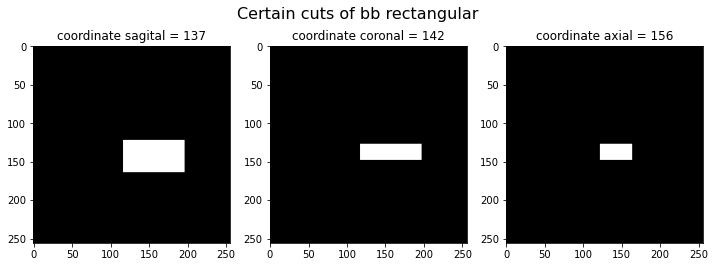

In [79]:
plot_certain_cuts(bb1, get_center_coord_of_bb(bb1), 'bb rectangular')

In [80]:
bb2 = load_nii_to_array('../datasets/ellipse_masks/fcd_2_1.nii.gz')

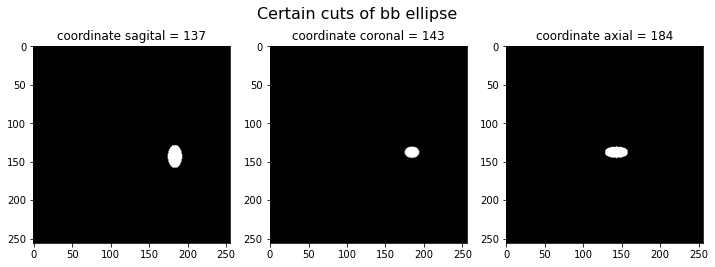

In [81]:
plot_certain_cuts(bb2, get_center_coord_of_bb(bb2), 'bb ellipse')

In [76]:
def plot_gt_pred(gt_slice, pred_slice, cmap = 'gray'):

    fig, (ax0, ax1) = plt.subplots(ncols=2, constrained_layout=True, figsize = (10, 10))
    
    ax0.imshow(gt_slice, cmap=cmap)
    ax0.set_title('Rectangular mask')
    ax0.grid(True)

    ax1.imshow(pred_slice, cmap=cmap)
    ax1.set_title('Ellipse mask')
    ax1.grid(True)

    plt.show()
    
def vary_coordinate(sagital, coronal, axial, axis = None):
    if axis == None:
        pass
    if axis == 'sagital':
        plot_gt_pred(bb1[sagital,:,:], bb2[sagital,:,:])
    if axis == 'coronal':
        plot_gt_pred(bb1[:,coronal ,:], bb2[:,coronal ,:] )
    if axis == 'axial':
        plot_gt_pred(bb1[:,:, axial], bb2[:,:, axial])

In [77]:
sld_sagital = IntSlider(min=0, max=bb1.shape[0]-1, step=1, continuous_update=True)
sld_coronal = IntSlider(min=0, max=bb1.shape[1]-1, step=1, continuous_update=True)
sld_axial   = IntSlider(min=0, max=bb1.shape[2]-1, step=1, continuous_update=True)
    
interact(vary_coordinate, 
     sagital = sld_sagital,
     coronal = sld_coronal,
     axial = sld_axial,
     axis = 'axial');

interactive(children=(IntSlider(value=0, description='sagital', max=255), IntSlider(value=0, description='coro…